# In this code I compute the theorical CMB Power spectrum with CAMB

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

In [4]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))

In [5]:
sys.path.insert(0,camb_path)

In [6]:
import camb
from camb import model, initialpower

In [7]:
pars=camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, mnu=0.06, omk=0.001, tau=0.0561)
pars.InitPower.set_params(As=2.105e-9, ns=0.9665, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [8]:
#calculate results for these parameters
results = camb.get_results(pars)

In [9]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [10]:
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
print(unlensedCL.shape)

(2551, 4)
(2551, 4)


In [15]:
ls = np.arange(totCL.shape[0])

# Correlation function with CAMB

In [1]:
r"""
Functions to transform CMB power spectrum into correlation functions cl2corr
"""
import numpy as np
import os

In [2]:
try:
    from .mathutils import gauss_legendre
except:
    # use np.polynomial.legendre if can't load fast native (so can use module without compiling camb)
    # Fortran version is much faster than current np.polynomial
    gauss_legendre = None


In [40]:
if not os.environ.get('READTHEDOCS', None):
    from scipy.special import lpn as legendreP
else:
    np.pi = 3.1415927  # needed to get docs right for np.pi/32 default argument

In [11]:
#  create a  empty dictionary
_gauss_legendre_cache = {}


In [12]:
#computes the legendre polynomials. 
#xvals and weights in dictionary
def _cached_gauss_legendre(npoints, cache=True):   # two parameters: npoints and cache
    if cache and npoints in _gauss_legendre_cache:
        return _gauss_legendre_cache[npoints]
    else:
        if gauss_legendre is not None:
            xvals = np.empty(npoints)
            weights = np.empty(npoints)
            gauss_legendre(xvals, weights, npoints)
            xvals.flags.writeable = False
            weights.flags.writeable = False
        else:
            xvals, weights = np.polynomial.legendre.leggauss(npoints)
        if cache:
            _gauss_legendre_cache[npoints] = xvals, weights
        return xvals, weights

In [34]:
def legendre_funcs(lmax, x, m=(0, 2), lfacs=None, lfacs2=None, lrootfacs=None):
    r"""
    Utility function to return array of Legendre and :math:`d_{mn}` functions for all :math:`\ell` up to lmax.
    Note that :math:`d_{mn}` arrays start at :math:`\ell_{\rm min} = \max(m,n)`, so returned arrays are different sizes

    :param lmax: maximum :math:`\ell`
    :param x: scalar value of :math:`\cos(\theta)` at which to evaluate
    :param m: m values to calculate :math:`d_{m,n}`, etc as relevant
    :param lfacs: optional pre-computed :math:`\ell(\ell+1)` float array
    :param lfacs2: optional pre-computed :math:`(\ell+2)*(\ell-1)` float array
    :param lrootfacs: optional pre-computed sqrt(lfacs*lfacs2) array
    :return: :math:`(P,P'),(d_{11},d_{-1,1}), (d_{20}, d_{22}, d_{2,-2})` as requested, where P starts
             at :math:`\ell=0`, but spin functions start at :math:`\ell=\ell_{\rm min}`
    """
    allP, alldP = legendreP(lmax, x)
    # Polarization functions all start at L=2
    fac1 = 1 - x
    fac2 = 1 + x
    res = []
    if 0 in m:
        res.append((allP, alldP))

    if 1 in m:
        lfacs1 = np.arange(1, lmax + 1, dtype=np.float64)
        lfacs1 *= (1 + lfacs1)
        d11 = fac1 * alldP[1:] / lfacs1 + allP[1:]
        dm11 = fac2 * alldP[1:] / lfacs1 - allP[1:]
        res.append((d11, dm11))

    if 2 in m:
        if lfacs is None:
            ls = np.arange(2, lmax + 1, dtype=np.float64)
            lfacs = ls * (ls + 1)
            lfacs2 = (ls + 2) * (ls - 1)
            lrootfacs = np.sqrt(lfacs * lfacs2)
        P = allP[2:]
        dP = alldP[2:]

        fac = fac1 / fac2
        d22 = (((4 * x - 8) / fac2 + lfacs) * P
               + 4 * fac * (fac2 + (x - 2) / lfacs) * dP) / lfacs2
        if x > 0.998:
              # for stability use series at small angles (thanks Pavel Motloch)
            d2m2 = np.empty(lmax - 1)
            indser = int(np.sqrt((400.0 + 3 / (1 - x ** 2)) / 150)) - 1
            d2m2[indser:] = ((lfacs[indser:] - (4 * x + 8) / fac1) * P[indser:]
                             + 4 / fac * (-fac1 + (x + 2) / lfacs[indser:]) * dP[indser:]) / lfacs2[indser:]
            sin2 = 1 - x ** 2
            d2m2[:indser] = lfacs[:indser] * lfacs2[:indser] * sin2 ** 2 / 7680 * (20 + sin2 * (16 - lfacs[:indser]))
        else:
            d2m2 = ((lfacs - (4 * x + 8) / fac1) * P
                    + 4 / fac * (-fac1 + (x + 2) / lfacs) * dP) / lfacs2
        d20 = (2 * x * dP - lfacs * P) / lrootfacs
        res.append((d20, d22, d2m2))

    return res

In [35]:
def cl2corr(cls, xvals, lmax=None):
    r"""
    Get the correlation function from the power spectra, evaluated at points cos(theta) = xvals.
    Use roots of Legendre polynomials (np.polynomial.legendre.leggauss) for accurate back integration with corr2cl.
    Note currently does not work at xvals=1 (can easily calculate that as special case!).

    :param cls: 2D array cls(L,ix), with L (:math:`\equiv \ell`) starting at zero and ix-0,1,2,3 in
                order TT, EE, BB, TE. cls should include :math:`\ell(\ell+1)/2\pi` factors.
    :param xvals: array of :math:`\cos(\theta)` values at which to calculate correlation function.
    :param lmax: optional maximum L to use from the cls arrays
    :return: 2D array of corrs[i, ix], where ix=0,1,2,3 are T, Q+U, Q-U and cross
    """

    if lmax is None:
        lmax = cls.shape[0] - 1
    xvals = np.asarray(xvals)
    ls = np.arange(0, lmax + 1, dtype=np.float64)
    corrs = np.zeros((len(xvals), 4))
    lfacs = ls * (ls + 1)
    lfacs[0] = 1
    facs = (2 * ls + 1) / (4 * np.pi) * 2 * np.pi / lfacs

    ct = facs * cls[:lmax + 1, 0]
    # For polarization, all arrays start at 2
    cp = facs[2:] * (cls[2:lmax + 1, 1] + cls[2:lmax + 1, 2])
    cm = facs[2:] * (cls[2:lmax + 1, 1] - cls[2:lmax + 1, 2])
    cc = facs[2:] * cls[2:lmax + 1, 3]
    ls = ls[2:]
    lfacs = lfacs[2:]
    lfacs2 = (ls + 2) * (ls - 1)
    lrootfacs = np.sqrt(lfacs * lfacs2)
    for i, x in enumerate(xvals):
        (P, _), (d20, d22, d2m2) = legendre_funcs(lmax, x, [0, 2], lfacs, lfacs2, lrootfacs)
        corrs[i, 0] = np.dot(ct, P)  # T
        corrs[i, 1] = np.dot(cp, d22)  # Q+U
        corrs[i, 2] = np.dot(cm, d2m2)  # Q-U
        corrs[i, 3] = np.dot(cc, d20)  # cross

    return corrs


In [55]:
totCL.shape


(2551, 4)

In [42]:
xvals=np.arange(-1,1,0.001)
xvals

array([-1.   , -0.999, -0.998, ...,  0.997,  0.998,  0.999])

In [54]:
cl2corr(totCL[:,0], xvals)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [45]:
from camb import #plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])

In [46]:
theta=np.linspace(0.1,np.pi,100)
x=np.cos(theta)

In [47]:
c_theta=camb.correlations.cl2corr(totCL, x, lmax=2000)

/home/augusto/anaconda3/envs/CMB/lib/python3.10/site-packages/camb/correlations.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  fac = fac1 / fac2
/home/augusto/anaconda3/envs/CMB/lib/python3.10/site-packages/camb/correlations.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  d22 = (((4 * x - 8) / fac2 + lfacs) * P
/home/augusto/anaconda3/envs/CMB/lib/python3.10/site-packages/camb/correlations.py:89: RuntimeWarning: invalid value encountered in add
  d22 = (((4 * x - 8) / fac2 + lfacs) * P


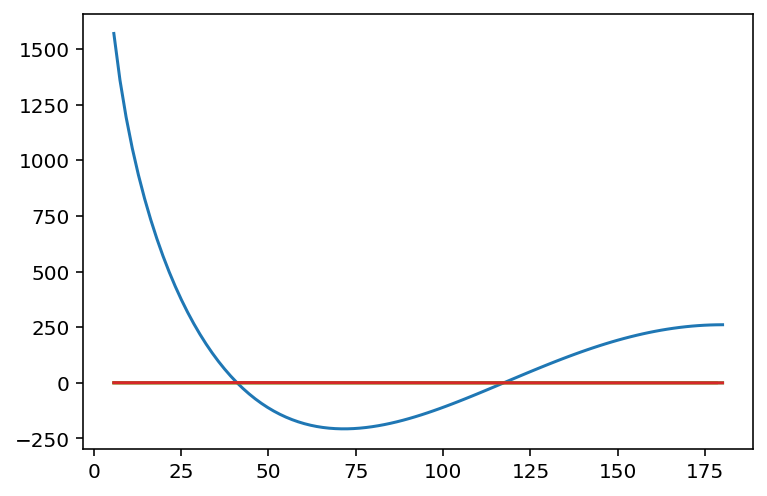

In [50]:
plt.plot(theta*180/np.pi,c_theta)

# Creation 10 maps with healpy routine synfast

In [52]:
lmax = 2500
nside=2048
mapa_cl_1 = hp.sphtfunc.synfast(totCL, nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_2 = hp.sphtfunc.synfast(totCL, nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_3 = hp.sphtfunc.synfast(totCL, nside=nside, lmax =lmax, fwhm=np.radians(5/60))

TypeError: The sequence of arrays must have either 4 elements or n(n+1)/2 elements (some may be None)